In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision import transforms
import einops
import time
from torch import nn
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy
import cv2

# Creating the spurious database.

In [2]:
""" Modified image dataset of colored images. This will return a dataset object
which can be passed on to dataloaders from torch. """

""" The color_map arg is a dictionary which record the colors to be assigned to the
 foreground of each class of image. """

## Optimised dataset using vectorisation and masks

class MNIST_Modified(Dataset):

  def __init__(self, color_map, easy_hard_split, bg_texture_intensity, perlin):

    self.perlin = perlin
    self.split = easy_hard_split
    self.texture_intensity = bg_texture_intensity
    self.color_map = torch.stack([color_map[i] for i in range(10)])[:, :, None, None]
    self.t = transforms.Compose([transforms.ToTensor()])
    self.assigned_colors = []
    self.training_dataset_original = datasets.MNIST(
        root = '/content/data', train = True, download = True, transform = self.t
        )
    self.color_img_flat_bg = self.color_maps()

    # Normalization of the dataset.

    mean = self.color_img_flat_bg.view(len(self.color_img_flat_bg), 3, -1).mean(dim=(0, 2))
    std = self.color_img_flat_bg.view(len(self.color_img_flat_bg), 3, -1).std(dim=(0, 2))
    self.color_img_flat_bg = (self.color_img_flat_bg - mean[None, :, None, None]) / std[None, :, None, None]
    self.color_img_text_bg = self.background_perlin()
    mean = self.color_img_text_bg.view(len(self.color_img_text_bg), 3, -1).mean(dim=(0, 2))
    std = self.color_img_text_bg.view(len(self.color_img_text_bg), 3, -1).std(dim=(0, 2))
    self.color_img_text_bg = (self.color_img_text_bg - mean[None, :, None, None]) / std[None, :, None, None]



  def color_maps(self):


    splitter_mask = torch.rand(len(self.training_dataset_original)) < self.split #shape is just 60K
    self.assigned_colors = self.color_map[self.training_dataset_original.targets]  # 60k, 3, 1, 1 Shape
    self.assigned_colors[~splitter_mask] = self.color_map[torch.randint(0, 10, [60000-splitter_mask.sum().item()])]
    return (self.training_dataset_original.data[:, None, :, :]*self.assigned_colors/255)

  def background_perlin(self):

    noise = self.assigned_colors * torch.rand([60000, 1, 28, 28]) * self.texture_intensity
    bg_noise = noise * (1 - self.training_dataset_original.data[:, None, :, :]/255)
    return self.assigned_colors * self.training_dataset_original.data[:, None, :, :]/255 + bg_noise

  def __len__(self):
    return len(self.training_dataset_original)

  def __getitem__(self, idx):
    if self.perlin:
      return self.color_img_text_bg[idx], self.training_dataset_original[idx][1]
    else:
      return self.color_img_flat_bg[idx], self.training_dataset_original[idx][1]


# Making Dataloaders for Train and Test

In [3]:

color_map = {
    0: torch.tensor([1.0, 0.0, 0.0]),   # Red        - R only
    1: torch.tensor([0.0, 1.0, 0.0]),   # Green      - G only
    2: torch.tensor([0.0, 0.0, 1.0]),   # Blue       - B only
    3: torch.tensor([1.0, 1.0, 0.0]),   # Yellow     - R+G
    4: torch.tensor([0.0, 1.0, 1.0]),   # Cyan       - G+B
    5: torch.tensor([1.0, 0.0, 1.0]),   # Magenta    - R+B
    6: torch.tensor([1.0, 0.6, 0.0]),   # Orange     - R + partial G
    7: torch.tensor([0.4, 0.0, 1.0]),   # Indigo     - partial R + B
    8: torch.tensor([0.0, 0.6, 0.3]),   # Teal       - partial G + partial B
    9: torch.tensor([1.0, 1.0, 1.0]),   # Rose       - R + partial B
}
color_map_inverted = {
    i: color_map[(i + 1) % 10]
    for i in range(10)
}
train_dataset = MNIST_Modified(color_map, 1, 0.4, True)
test_dataset = MNIST_Modified(color_map_inverted, 1, 0.4, True)




100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.99MB/s]


In [ ]:
train_dataset_flat = MNIST_Modified(color_map, 0.99, 0.25, False)
test_dataset_flat = MNIST_Modified(color_map_inverted, 1, 0.25, False)



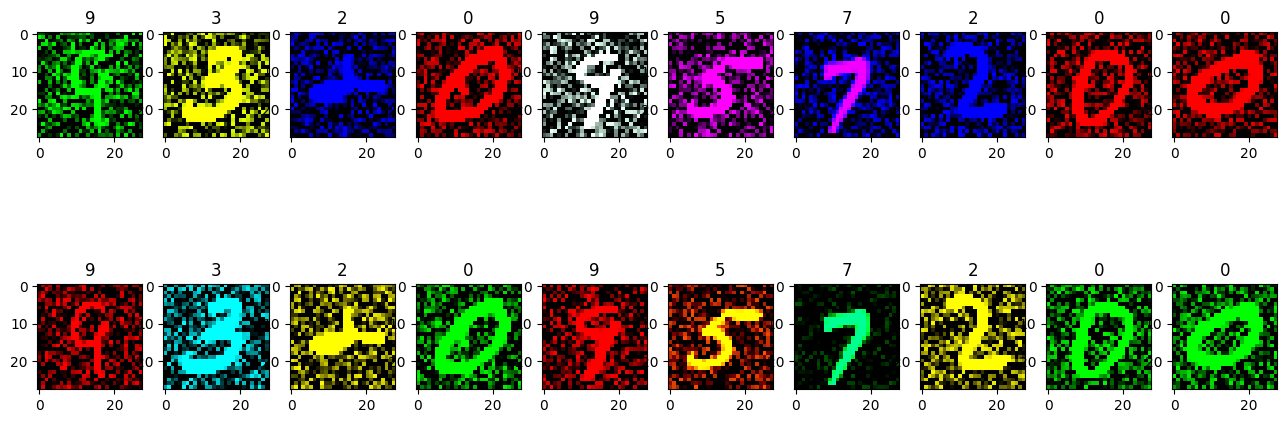

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(16, 6))

for i in range(10):
  f = torch.randint(60000, (1,)).item()
  axes[0, i].imshow(einops.rearrange(train_dataset[f][0], 'c h w -> h w c'))
  axes[0, i].set_title(train_dataset[f][1])
  axes[1, i].imshow(einops.rearrange(test_dataset[f][0], 'c h w -> h w c'))
  axes[1, i].set_title(test_dataset[f][1])
plt.show()



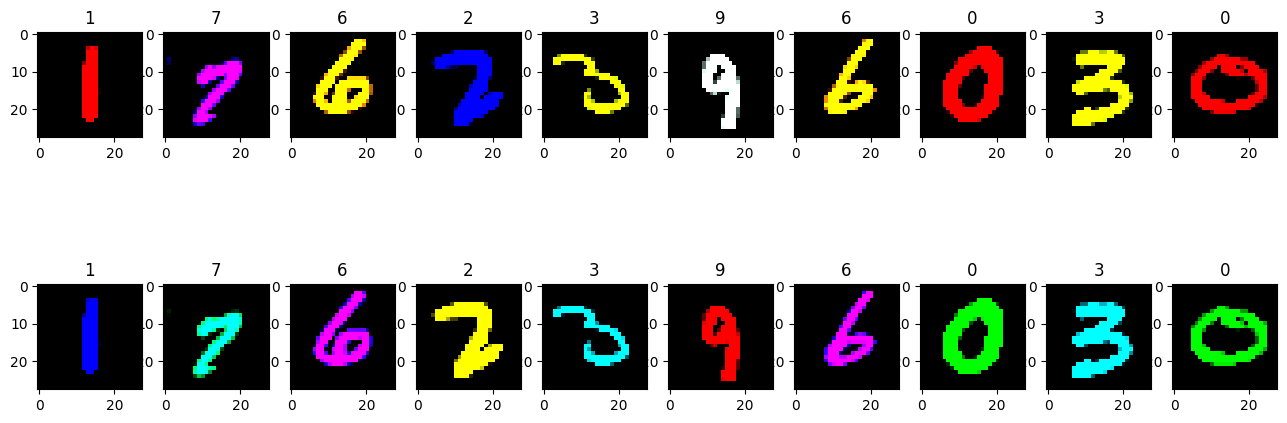

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(16, 6))

for i in range(10):
  f = torch.randint(60000, (1,)).item()
  axes[0, i].imshow(einops.rearrange(train_dataset_flat[f][0], 'c h w -> h w c'))
  axes[0, i].set_title(train_dataset_flat[f][1])
  axes[1, i].imshow(einops.rearrange(test_dataset_flat[f][0], 'c h w -> h w c'))
  axes[1, i].set_title(test_dataset_flat[f][1])
plt.show()

# Configuring Models and Training Device

In [ ]:

class CNN1(nn.Module):
  def __init__(self, l1, l2, l3):
    super().__init__()
    self.con_layer1 = nn.Conv2d(in_channels = 3, out_channels = l1, kernel_size=5, padding=1)
    self.con_layer2 = nn.Conv2d(in_channels = l1, out_channels = l2, kernel_size=3, padding=1)
    self.con_layer3 = nn.Conv2d(in_channels = l2, out_channels = l3, kernel_size = 5, padding = 1)
    self.max_pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.flat1 = nn.LazyLinear(10)

    self.model = nn.Sequential(
        self.con_layer1, nn.ReLU(), self.max_pool,
        self.con_layer2, nn.ReLU(), self.max_pool,
        self.con_layer3, nn.ReLU(), self.max_pool,
        nn.Flatten(),
        self.flat1

        )

  def forward(self, x):
    return self.model(x)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNetMNIST(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetMNIST, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 2, stride=1)  # 28x28
        self.layer2 = self._make_layer(128, 2, stride=2) # 14x14
        self.layer3 = self._make_layer(256, 2, stride=2) # 7x7
        self.layer4 = self._make_layer(512, 2, stride=2) # 4x4
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out



## Task 1: Training Model.
CNN model , with 95% bias (background noise)

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size = batch_size , shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
model = CNN1(16, 16, 32)
model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):

    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


loss_fn = nn.CrossEntropyLoss()


epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Using cuda device
Epoch 1
-------------------------------
loss: 2.352607  [  256/60000]
loss: 0.212264  [25856/60000]
loss: 0.142172  [51456/60000]
Test Error: 
 Accuracy: 45.6%, Avg loss: 1.607659 

Epoch 2
-------------------------------
loss: 0.114917  [  256/60000]
loss: 0.101157  [25856/60000]
loss: 0.121472  [51456/60000]
Test Error: 
 Accuracy: 70.5%, Avg loss: 0.892885 

Epoch 3
-------------------------------
loss: 0.028698  [  256/60000]
loss: 0.032237  [25856/60000]
loss: 0.015889  [51456/60000]
Test Error: 
 Accuracy: 78.6%, Avg loss: 0.770779 

Epoch 4
-------------------------------
loss: 0.068156  [  256/60000]
loss: 0.039311  [25856/60000]
loss: 0.030118  [51456/60000]
Test Error: 
 Accuracy: 85.9%, Avg loss: 0.445005 

Epoch 5
-------------------------------
loss: 0.025261  [  256/60000]
loss: 0.031213  [25856/60000]
loss: 0.005190  [51456/60000]
Test Error: 
 Accuracy: 85.6%, Avg loss: 0.480847 

Epoch 6
-------------------------------
loss: 0.010396  [  256/60000]
lo

# Training CNN on dataset with 99% bias (background noise)

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size = batch_size , shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
model = CNN1(16, 16, 32)
model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):

    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


loss_fn = nn.CrossEntropyLoss()


epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Using cuda device
Epoch 1
-------------------------------
loss: 2.296244  [  256/60000]
loss: 0.056022  [25856/60000]
loss: 0.093267  [51456/60000]
Test Error: 
 Accuracy: 0.1%, Avg loss: 6.072015 

Epoch 2
-------------------------------
loss: 0.034441  [  256/60000]
loss: 0.064668  [25856/60000]
loss: 0.057000  [51456/60000]
Test Error: 
 Accuracy: 16.0%, Avg loss: 3.660907 

Epoch 3
-------------------------------
loss: 0.015160  [  256/60000]
loss: 0.017888  [25856/60000]
loss: 0.018558  [51456/60000]
Test Error: 
 Accuracy: 20.0%, Avg loss: 3.310535 

Epoch 4
-------------------------------
loss: 0.032999  [  256/60000]
loss: 0.017637  [25856/60000]
loss: 0.089411  [51456/60000]
Test Error: 
 Accuracy: 40.3%, Avg loss: 2.340926 

Epoch 5
-------------------------------
loss: 0.029283  [  256/60000]
loss: 0.006461  [25856/60000]
loss: 0.019299  [51456/60000]
Test Error: 
 Accuracy: 40.3%, Avg loss: 2.178657 

Epoch 6
-------------------------------
loss: 0.013984  [  256/60000]
los

# CNN with Flat background dataset , 99% bias

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
batch_size = 256
train_dataloader = DataLoader(train_dataset_flat, batch_size = batch_size , shuffle = True)
test_dataloader = DataLoader(test_dataset_flat, batch_size = batch_size, shuffle = True)
model = CNN1(16, 16, 32)
model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):

    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


loss_fn = nn.CrossEntropyLoss()


epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Using cuda device
Epoch 1
-------------------------------
loss: 2.304136  [  256/60000]
loss: 0.085868  [25856/60000]
loss: 0.070295  [51456/60000]
Test Error: 
 Accuracy: 1.2%, Avg loss: 5.455813 

Epoch 2
-------------------------------
loss: 0.053608  [  256/60000]
loss: 0.032272  [25856/60000]
loss: 0.021628  [51456/60000]
Test Error: 
 Accuracy: 15.6%, Avg loss: 3.870162 

Epoch 3
-------------------------------
loss: 0.061669  [  256/60000]
loss: 0.043923  [25856/60000]
loss: 0.022281  [51456/60000]
Test Error: 
 Accuracy: 29.2%, Avg loss: 2.539683 

Epoch 4
-------------------------------
loss: 0.014835  [  256/60000]
loss: 0.016436  [25856/60000]
loss: 0.023877  [51456/60000]
Test Error: 
 Accuracy: 32.5%, Avg loss: 2.296775 

Epoch 5
-------------------------------
loss: 0.018575  [  256/60000]
loss: 0.005910  [25856/60000]
loss: 0.037278  [51456/60000]
Test Error: 
 Accuracy: 49.8%, Avg loss: 1.718216 

Epoch 6
-------------------------------
loss: 0.014180  [  256/60000]
los

# Trainig a ResNET18 using the same flow of techniques.

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size = batch_size , shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
model2 = ResNetMNIST()
model2.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001, betas=(0.9, 0.999))

def train_loop(dataloader, model2, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model2.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model2(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model2, loss_fn):

    model2.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model2(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


loss_fn = nn.CrossEntropyLoss()


epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model2, loss_fn, optimizer)
    test_loop(test_dataloader, model2, loss_fn)
print("Done!")

Using cuda device
Epoch 1
-------------------------------
loss: 2.404159  [  256/60000]
loss: 0.241291  [25856/60000]
loss: 0.081253  [51456/60000]
Test Error: 
 Accuracy: 52.1%, Avg loss: 1.391068 

Epoch 2
-------------------------------
loss: 0.130751  [  256/60000]
loss: 0.053891  [25856/60000]
loss: 0.044466  [51456/60000]
Test Error: 
 Accuracy: 81.9%, Avg loss: 0.585010 

Epoch 3
-------------------------------
loss: 0.021971  [  256/60000]
loss: 0.020671  [25856/60000]
loss: 0.027377  [51456/60000]
Test Error: 
 Accuracy: 89.4%, Avg loss: 0.315297 

Epoch 4
-------------------------------
loss: 0.006162  [  256/60000]
loss: 0.022606  [25856/60000]
loss: 0.013226  [51456/60000]
Test Error: 
 Accuracy: 93.9%, Avg loss: 0.202445 

Epoch 5
-------------------------------
loss: 0.006867  [  256/60000]
loss: 0.028009  [25856/60000]
loss: 0.014211  [51456/60000]
Test Error: 
 Accuracy: 92.3%, Avg loss: 0.265767 

Done!


## Now we will create the 0-5 dataset and train our models on
it to diagnose if visual separability of colors was the problem

In [ ]:

""" Modified image dataset of colored images. This will return a dataset object
which can be passed on to dataloaders from torch. """

""" The color_map arg is a dictionary which record the colors to be assigned to the
 foreground of each class of image. """

## Optimised dataset using vectorisation and masks

class MNIST_Modified0_5(Dataset):

  def __init__(self, color_map, easy_hard_split, bg_texture_intensity, perlin):

    self.perlin = perlin
    self.split = easy_hard_split
    self.texture_intensity = bg_texture_intensity
    self.color_map = torch.stack([color_map[i] for i in range(6)])[:, :, None, None]
    self.t = transforms.Compose([transforms.ToTensor()])
    self.assigned_colors = []
    self.training_dataset_original = datasets.MNIST(
        root = '/content/data', train = True, download = True, transform = self.t
        )
    self.indices = self.training_dataset_original.targets <= 5
    self.data = self.training_dataset_original.data[self.indices]
    self.targets = self.training_dataset_original.targets[self.indices]
    self.color_img_flat_bg = self.color_maps()
    self.color_img_text_bg = self.background_perlin()

  def color_maps(self):

    splitter_mask = torch.rand(len(self.data)) < self.split #shape is just 60K
    self.assigned_colors = self.color_map[self.targets]  # 60k, 3, 1, 1 Shape
    self.assigned_colors[~splitter_mask] = self.color_map[torch.randint(0, 6, [len(self.data)-splitter_mask.sum().item()])]
    return (self.data[:, None, :, :]*self.assigned_colors/255)

  def background_perlin(self):

    noise = self.assigned_colors * torch.rand([len(self.data), 1, 28, 28]) * self.texture_intensity
    bg_noise = noise * (1 - self.data[:, None, :, :]/255)
    return self.assigned_colors * self.data[:, None, :, :]/255 + bg_noise

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    if self.perlin:
      return self.color_img_text_bg[idx], self.targets[idx]
    else:
      return self.color_img_flat_bg[idx], self.targets[idx]


In [ ]:
color_map = {
    0: torch.tensor([1.0, 0.0, 0.0]),   # Red        - R only
    1: torch.tensor([0.0, 1.0, 0.0]),   # Green      - G only
    2: torch.tensor([0.0, 0.0, 1.0]),   # Blue       - B only
    3: torch.tensor([1.0, 1.0, 0.0]),   # Yellow     - R+G
    4: torch.tensor([0.0, 1.0, 1.0]),   # Cyan       - G+B

    5: torch.tensor([1.0, 1.0, 1.0]),   # Rose       - R + partial B
}
color_map_inverted = {
    i:color_map[(i+1)%6] for i in range(6)
}



In [ ]:
new = MNIST_Modified0_5(color_map, 0.99, 0.3, True)
new_test = MNIST_Modified0_5(color_map_inverted, 1, 0.3, True)

In [ ]:
new_flat = MNIST_Modified0_5(color_map, 0.99, 0.3, False)
new_test_flat = MNIST_Modified0_5(color_map_inverted, 1, 0.3, False)


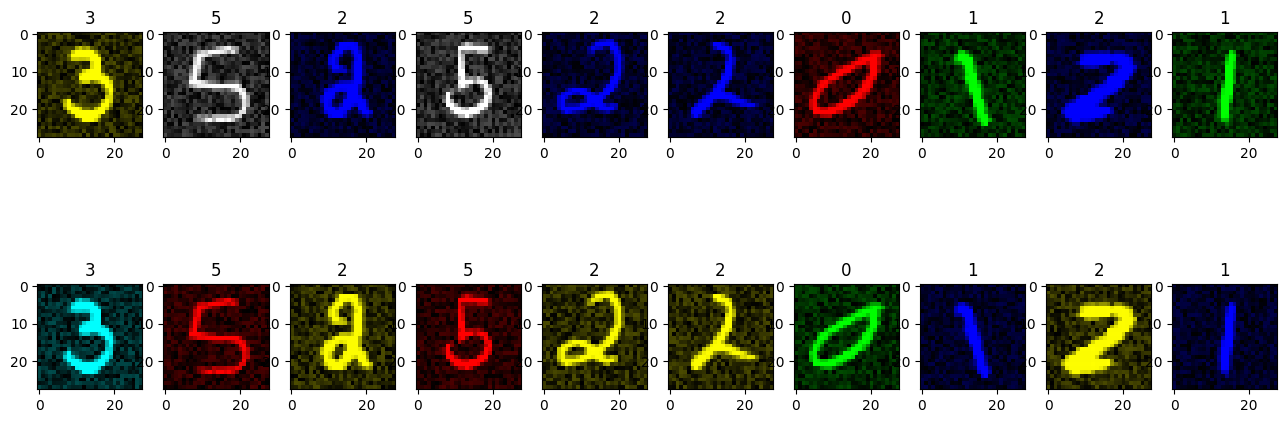

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(16, 6))

for i in range(10):
  f = torch.randint(len(new), (1,)).item()
  axes[0, i].imshow(einops.rearrange(new[f][0], 'c h w -> h w c'))
  axes[0, i].set_title(new[f][1].item())
  axes[1, i].imshow(einops.rearrange(new_test[f][0], 'c h w -> h w c'))
  axes[1, i].set_title(new_test[f][1].item())
plt.show()


# Training on 0-5 99% biased image dataset with background noise.

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
batch_size = 64
train_dataloader = DataLoader(new, batch_size = batch_size , shuffle = True)
test_dataloader = DataLoader(new_test, batch_size = batch_size, shuffle = True)
model = CNN1(16, 16, 32)
model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):

    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


loss_fn = nn.CrossEntropyLoss()


epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Using cuda device
Epoch 1
-------------------------------
loss: 2.302196  [   64/36017]
loss: 0.064648  [ 6464/36017]
loss: 0.013585  [12864/36017]
loss: 0.111302  [19264/36017]
loss: 0.008172  [25664/36017]
loss: 0.004844  [32064/36017]
Test Error: 
 Accuracy: 1.1%, Avg loss: 4.888956 

Epoch 2
-------------------------------
loss: 0.006227  [   64/36017]
loss: 0.161325  [ 6464/36017]
loss: 0.080600  [12864/36017]
loss: 0.138090  [19264/36017]
loss: 0.003869  [25664/36017]
loss: 0.002962  [32064/36017]
Test Error: 
 Accuracy: 30.3%, Avg loss: 1.948722 

Epoch 3
-------------------------------
loss: 0.005159  [   64/36017]
loss: 0.037199  [ 6464/36017]
loss: 0.006324  [12864/36017]
loss: 0.002003  [19264/36017]
loss: 0.001462  [25664/36017]
loss: 0.003481  [32064/36017]
Test Error: 
 Accuracy: 62.3%, Avg loss: 0.946129 

Epoch 4
-------------------------------
loss: 0.006689  [   64/36017]
loss: 0.003410  [ 6464/36017]
loss: 0.011550  [12864/36017]
loss: 0.010024  [19264/36017]
loss: 0

# Training on 99% bias flat backgorund

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
batch_size = 64
train_dataloader = DataLoader(new_flat, batch_size = batch_size , shuffle = True)
test_dataloader = DataLoader(new_test_flat, batch_size = batch_size, shuffle = True)
model = CNN1(16, 16, 32)
model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):

    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


loss_fn = nn.CrossEntropyLoss()


epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Using cuda device
Epoch 1
-------------------------------
loss: 2.258534  [   64/36017]
loss: 0.009779  [ 6464/36017]
loss: 0.014732  [12864/36017]
loss: 0.013400  [19264/36017]
loss: 0.010036  [25664/36017]
loss: 0.005694  [32064/36017]
Test Error: 
 Accuracy: 4.2%, Avg loss: 4.105687 

Epoch 2
-------------------------------
loss: 0.003682  [   64/36017]
loss: 0.001381  [ 6464/36017]
loss: 0.096995  [12864/36017]
loss: 0.010553  [19264/36017]
loss: 0.047174  [25664/36017]
loss: 0.053872  [32064/36017]
Test Error: 
 Accuracy: 44.3%, Avg loss: 1.777273 

Epoch 3
-------------------------------
loss: 0.060189  [   64/36017]
loss: 0.020720  [ 6464/36017]
loss: 0.005670  [12864/36017]
loss: 0.007533  [19264/36017]
loss: 0.039486  [25664/36017]
loss: 0.056030  [32064/36017]
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.237843 

Epoch 4
-------------------------------
loss: 0.015314  [   64/36017]
loss: 0.008661  [ 6464/36017]
loss: 0.000149  [12864/36017]
loss: 0.065428  [19264/36017]
loss: 0

## Now we will train on the 100% biased background noise dataset
## and we wil observe that the model fails miserably ->0% accuracy


In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size = batch_size , shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
modl = CNN1(16, 16, 32)
modl.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modl.parameters(), lr=0.001, betas=(0.9, 0.999))

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):

    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


loss_fn = nn.CrossEntropyLoss()


epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, modl, loss_fn, optimizer)
    test_loop(test_dataloader, modl, loss_fn)
print("Done!")

Using cuda device
Epoch 1
-------------------------------
loss: 2.329511  [  256/60000]
loss: 0.000462  [25856/60000]
loss: 0.000172  [51456/60000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 28.149443 

Epoch 2
-------------------------------
loss: 0.000137  [  256/60000]
loss: 0.000079  [25856/60000]
loss: 0.000072  [51456/60000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 30.526270 

Epoch 3
-------------------------------
loss: 0.000051  [  256/60000]
loss: 0.000038  [25856/60000]
loss: 0.000059  [51456/60000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 32.259727 

Epoch 4
-------------------------------
loss: 0.000042  [  256/60000]
loss: 0.000022  [25856/60000]
loss: 0.000021  [51456/60000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 33.686188 

Epoch 5
-------------------------------
loss: 0.000025  [  256/60000]
loss: 0.000022  [25856/60000]
loss: 0.000014  [51456/60000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 34.796722 

Done!


This clearly shows that train loss plummets instantly -> model relies heavily on the color metri but test accuracy goes to 0 and never improves.

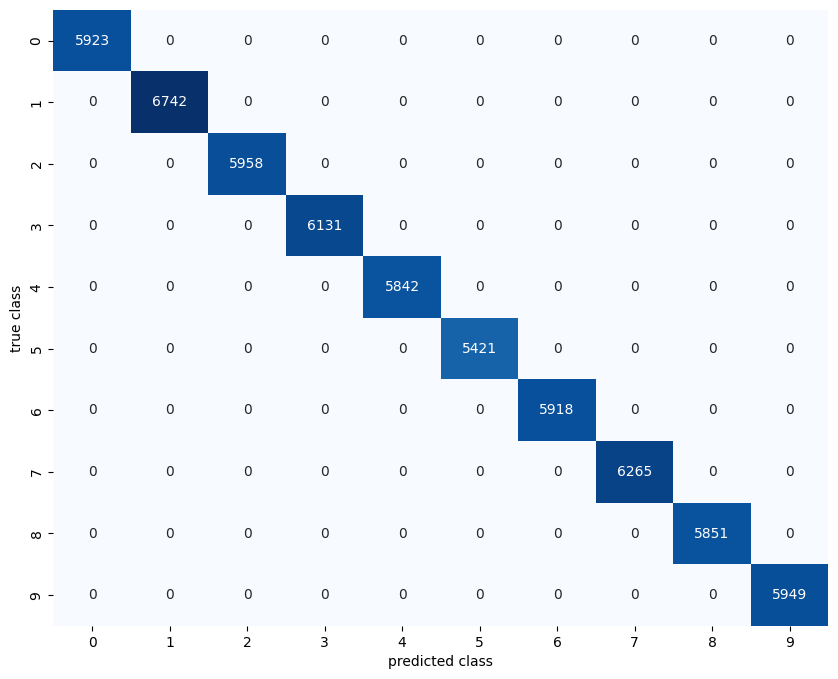

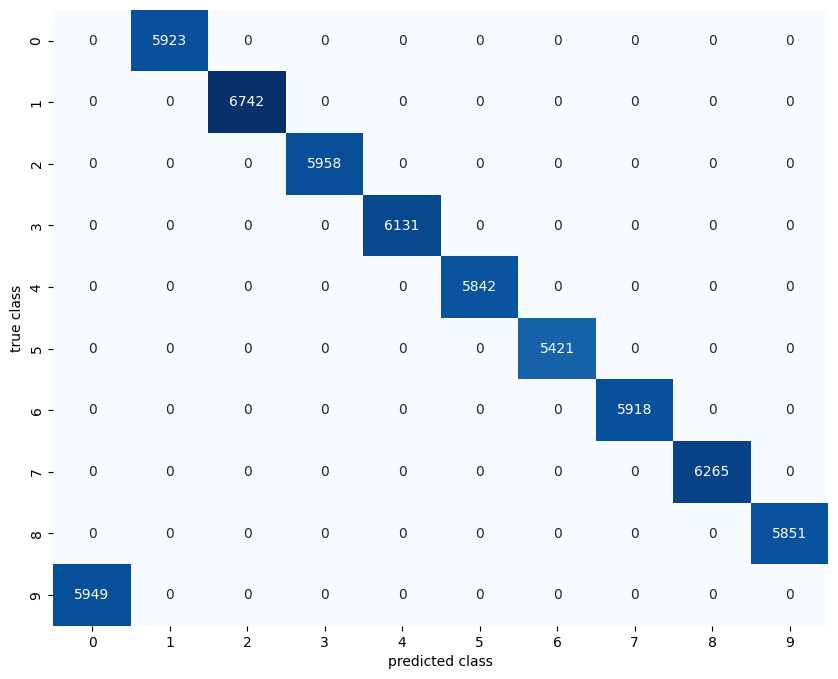

array([[   0, 5923,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 6742,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 5958,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 6131,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0, 5842,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 5421,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 5918,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 6265,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 5851],
       [5949,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [ ]:
def conf_matrix(model, dataloader, classes, device = device):
  model.eval()
  prediction = []
  true = []
  with torch.no_grad():
    for x, y in dataloader:
      x = x.to(device)
      y = y.to(device)
      preds = model(x)
      _, preds = torch.max(preds ,1)
      true.extend(y.cpu().numpy())
      prediction.extend(preds.cpu().numpy())

  matrix = confusion_matrix(true, prediction)

  plt.figure(figsize = (10,8))

  dataframe_matrix = pd.DataFrame(matrix, index=classes, columns=classes)
  heatmap = sns.heatmap(dataframe_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.ylabel("true class")
  plt.xlabel('predicted class')
  plt.show()
  return matrix

classes = [str(i) for i in color_map.keys()]

conf_matrix(model2, train_dataloader, classes)
conf_matrix(model2, test_dataloader, classes)

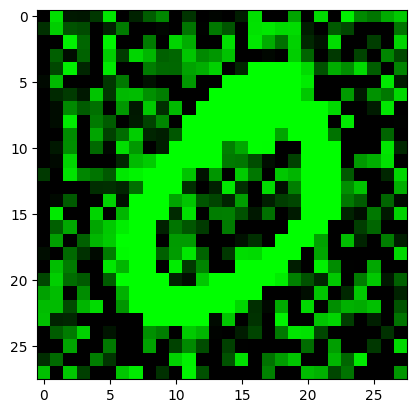

The predicted class is 1


In [ ]:
""" Feeding the model a green 0 Image, we expect it to predict a 1 """
img = train_dataset[1][0]
img = img[[1, 0 ,2], :, :]
plt.imshow(einops.rearrange(img, 'c h w -> h w c'))
plt.show()
model2.eval()
img = img.to(device)
print(f"The predicted class is {model2(img[None, :, :, :]).argmax(dim = 1).item()}")

## Custom Analysis : RSV of the weight matrices


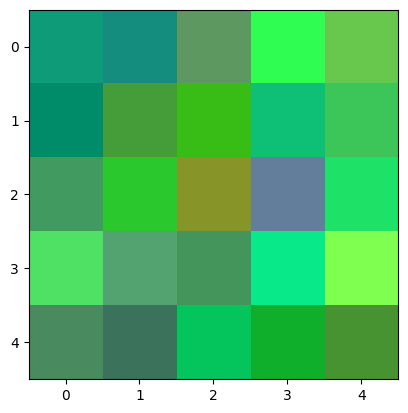

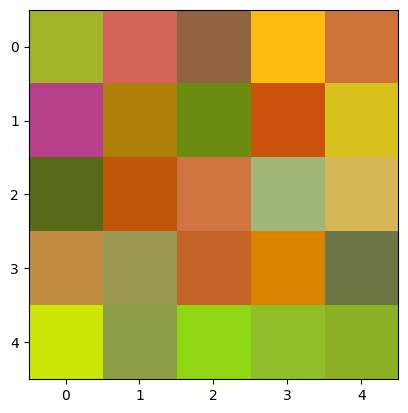

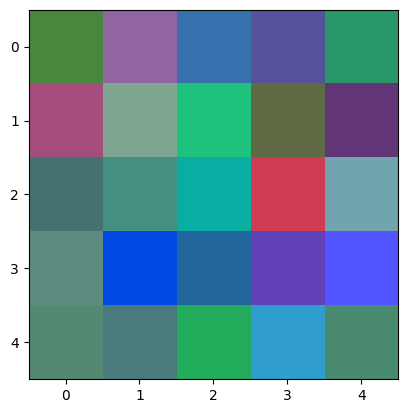

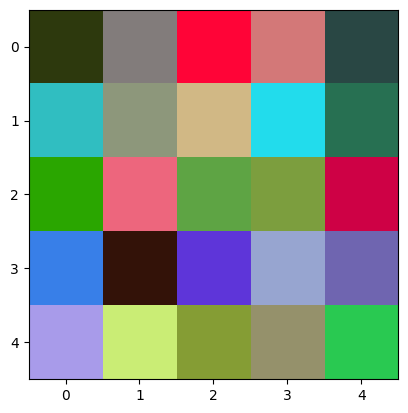

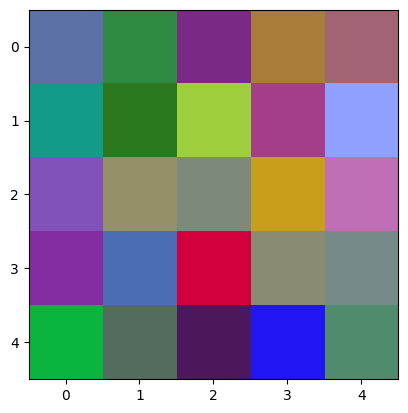

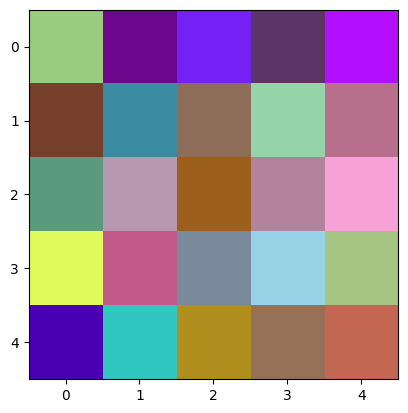

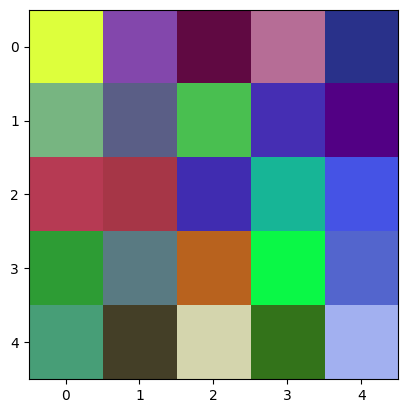

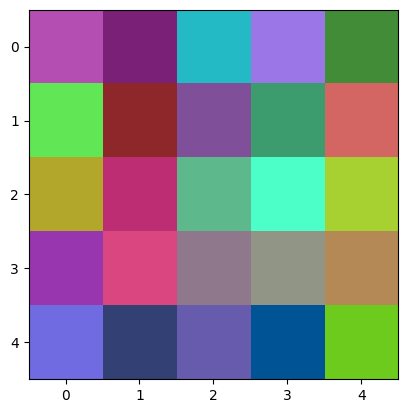

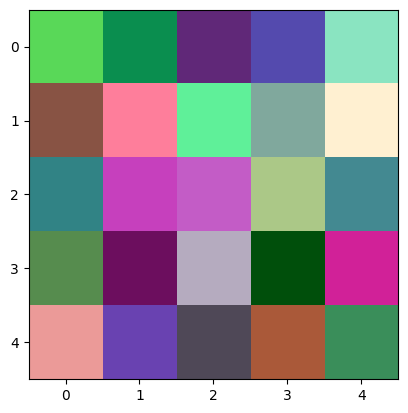

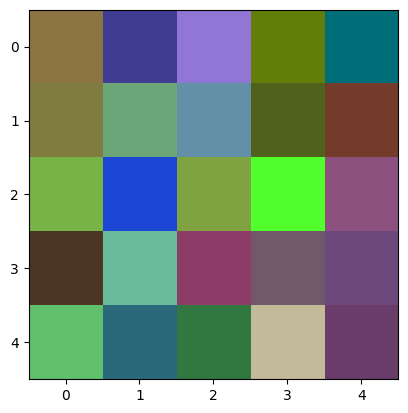

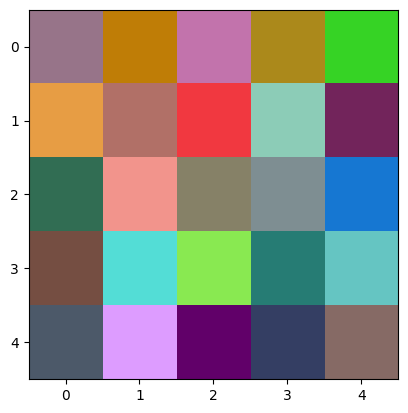

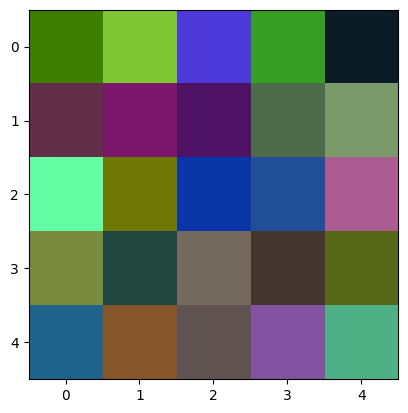

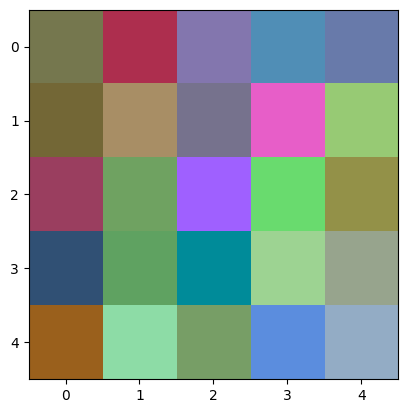

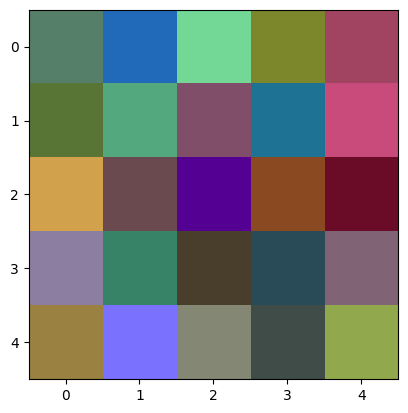

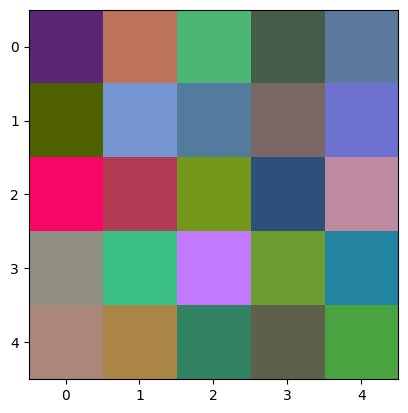

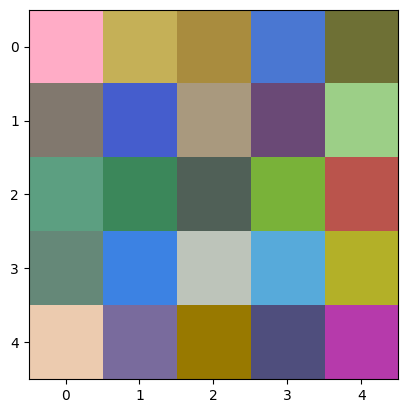

tensor([1.1596, 1.1034, 0.9887, 0.8240, 0.7056, 0.6920, 0.6542, 0.6093, 0.5693,
        0.5494, 0.4913, 0.4630, 0.4376, 0.4369, 0.3826, 0.3417],
       device='cuda:0')


In [ ]:
def RSV_analysis(model):
  weight = model.con_layer1.weight.data.detach()
  weight = weight.view(weight.size(0), -1)

  U, S, Vh = torch.linalg.svd(weight, full_matrices=False)

  Vh = Vh.view(16, 3, 5, 5)

  return Vh.cpu(), S

v , s= RSV_analysis(model)
for i in v:
  i = i - i.min()
  i = i / i.max()
  plt.imshow(einops.rearrange(i.squeeze(), 'c h w -> h w c'))
  plt.show()

print(s)

##So we have proven that the model is lazy and does indeed fall back on color

##Smaller dataset. 0-5

# Task 2 Prober

LAZY MODEL


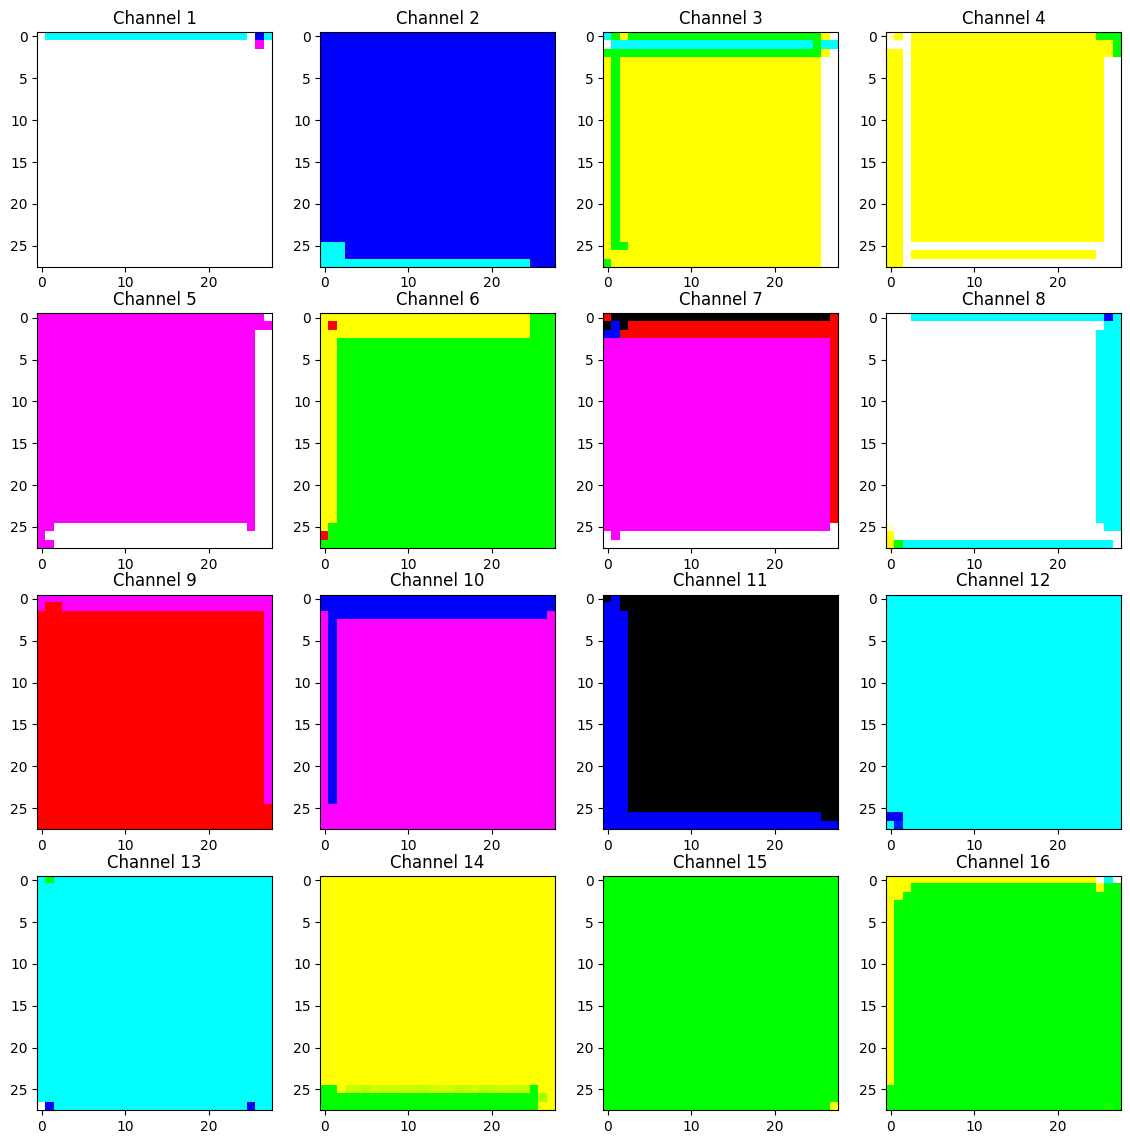

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

class image_optimiser():
  def __init__(self, model, lr = 0.1, step = 400, device = device):
    self.model = model
    self.model.eval()
    self.lr = lr
    self.step = step
    self.activation_dictionary = {}

  def activation_collector(self, layer_name):

    def data_hook(model, input, output):
      self.activation_dictionary[layer_name] = output
    return data_hook

  def maximiser(self, layer_index, layer_name, filter_index):
    hook = layer_index.register_forward_hook(self.activation_collector(layer_name))
    self.model.eval()
    image = torch.rand(1, 3, 28, 28, device = device, requires_grad = True)
    image = image.to(device)
    optimiser = torch.optim.Adam([image], lr = self.lr)

    for i in range(self.step):
      optimiser.zero_grad()
      output = model(image)
      loss = - self.activation_dictionary[layer_name][0,filter_index].mean() + 0.01*torch.norm(image)
      loss.backward()
      optimiser.step()

    hook.remove()

    return image.detach().cpu().numpy()

image_maximiser = image_optimiser(model)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(14, 14))

for i in range(16):
  image = image_maximiser.maximiser(model.con_layer1,'layer1', i).squeeze(0)
  axes[i//4, i%4].imshow(einops.rearrange(image,'c h w -> h w c' ))

  axes[i//4, i%4].set_title(f"Channel {i + 1}")

plt.show()





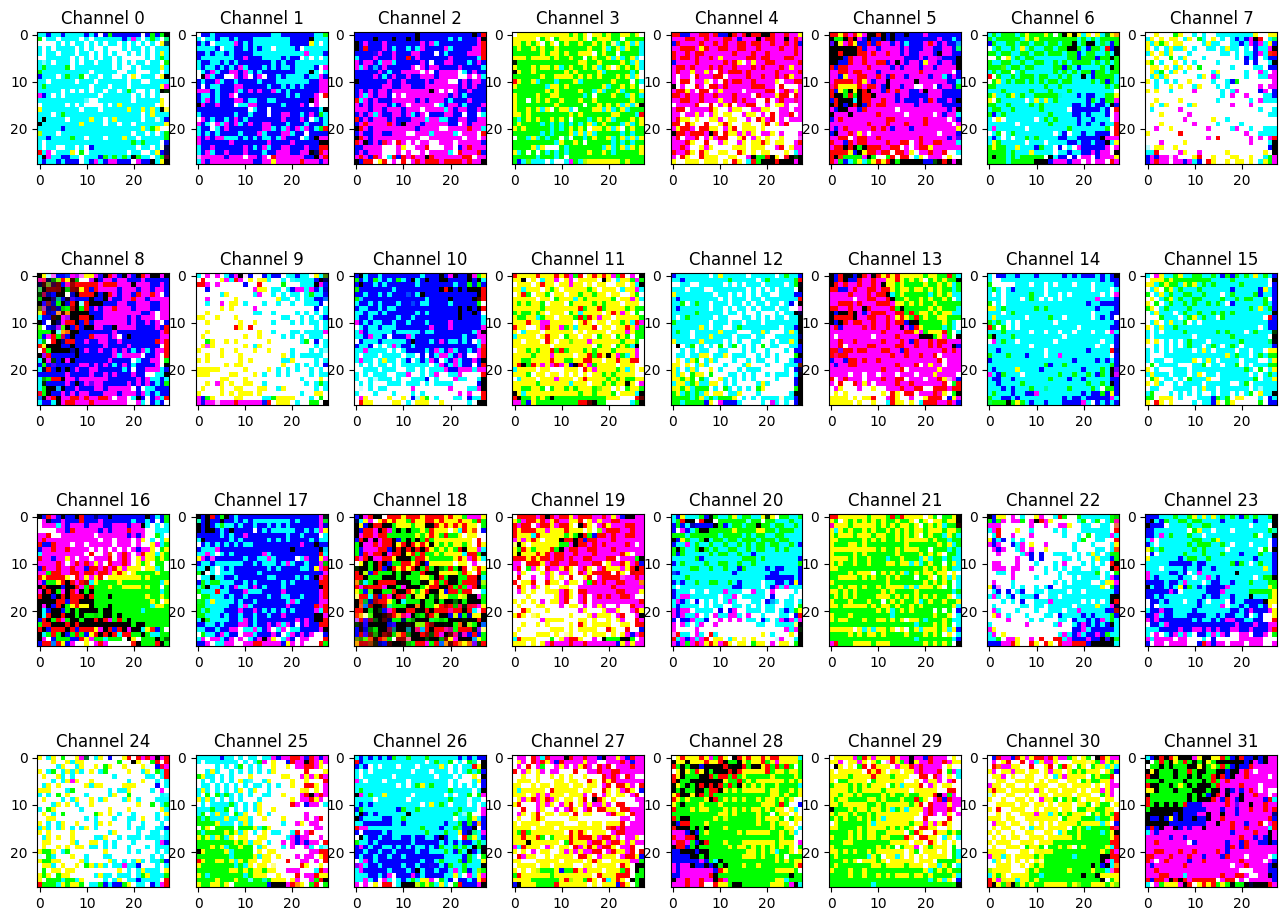

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 12))

for i in range(32):
  image = image_maximiser.maximiser(model.con_layer3,'layer3', i).squeeze(0)
  axes[i//8, i%8].imshow(einops.rearrange(image,'c h w -> h w c' ))

  axes[i//8, i%8].set_title(f"Channel {i}")

plt.show()

torch.Size([1, 16, 26, 26])
tensor(14185.2529, device='cuda:0', grad_fn=<SumBackward0>) 0
tensor(64755.3359, device='cuda:0', grad_fn=<SumBackward0>) 1
tensor(-21417.9434, device='cuda:0', grad_fn=<SumBackward0>) 2
tensor(-29927.6914, device='cuda:0', grad_fn=<SumBackward0>) 3
tensor(1909.0312, device='cuda:0', grad_fn=<SumBackward0>) 4
tensor(-25338.0430, device='cuda:0', grad_fn=<SumBackward0>) 5
tensor(311.5691, device='cuda:0', grad_fn=<SumBackward0>) 6
tensor(7228.3271, device='cuda:0', grad_fn=<SumBackward0>) 7
tensor(-21559.6602, device='cuda:0', grad_fn=<SumBackward0>) 8
tensor(39629.0820, device='cuda:0', grad_fn=<SumBackward0>) 9
tensor(39929.3867, device='cuda:0', grad_fn=<SumBackward0>) 10
tensor(41549.4375, device='cuda:0', grad_fn=<SumBackward0>) 11
tensor(37660.1445, device='cuda:0', grad_fn=<SumBackward0>) 12
tensor(-43398.6953, device='cuda:0', grad_fn=<SumBackward0>) 13
tensor(-23687.9883, device='cuda:0', grad_fn=<SumBackward0>) 14
tensor(-20298.3672, device='cuda:0'

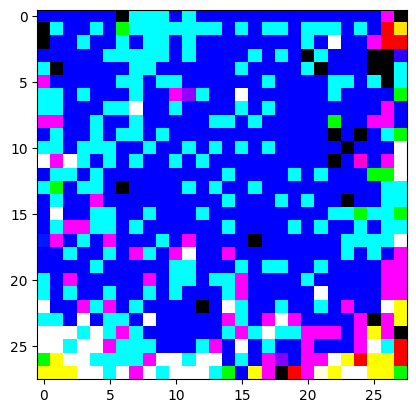

In [ ]:
image_maximiser = image_optimiser(model)
image = image_maximiser.maximiser(model.flat1,'layer1', 2)
plt.imshow(einops.rearrange(image.squeeze(), ' c h w -> h w c'))
image = torch.tensor(image)
image = image.to(device)

d = {}

def act_mat(name):
  def hook(model, input, output):
    d[name] = output
  return hook
model.con_layer1.register_forward_hook(act_mat('layer1'))
model(image)
print(d['layer1'].shape)
l = d['layer1'].squeeze()
for j,i in enumerate(l):
  print(i.sum(), j)

ROBUST MODEL

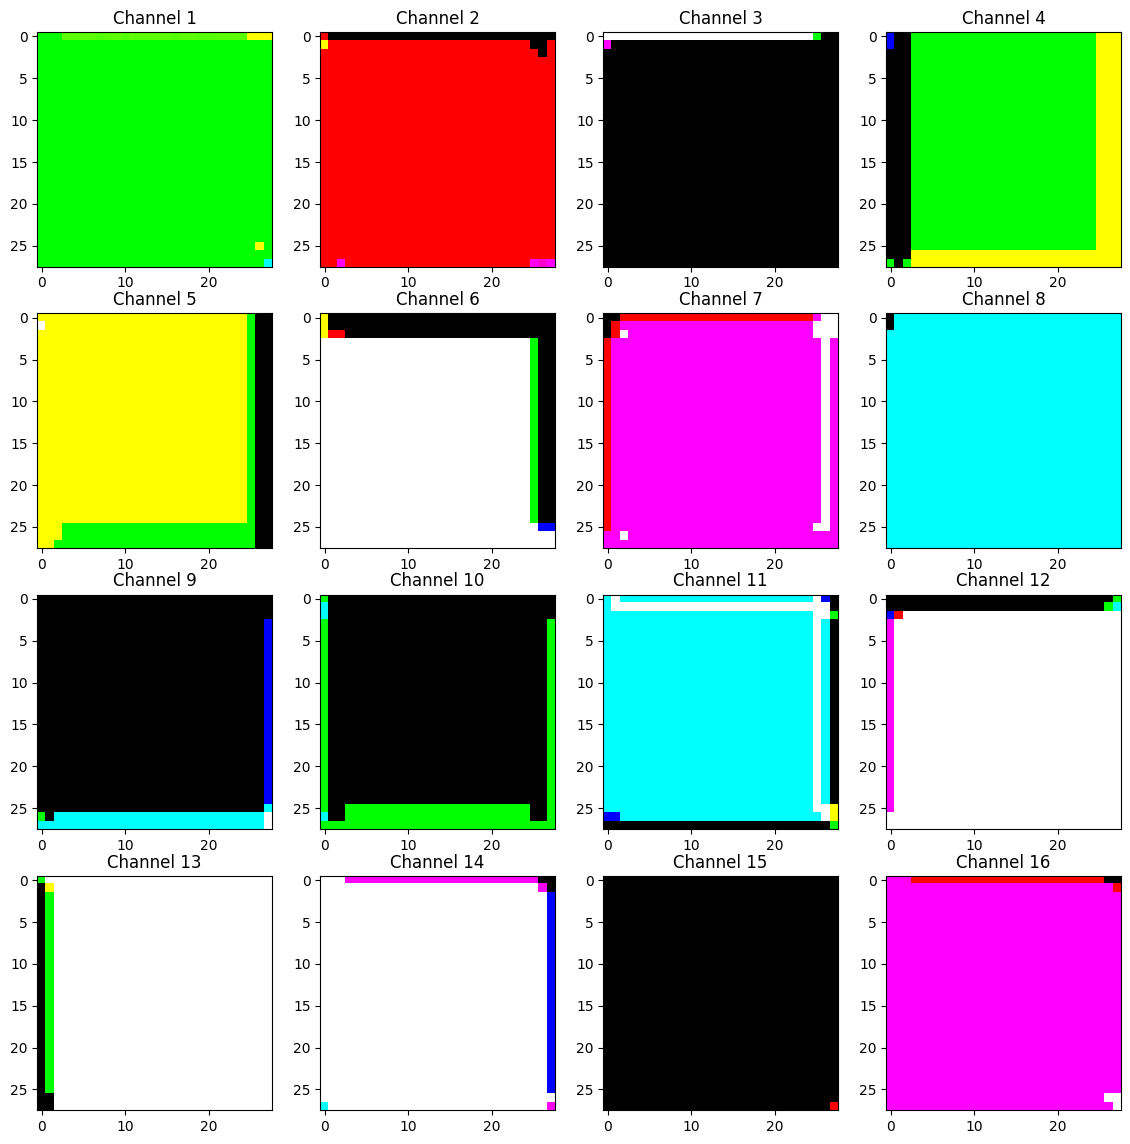

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

image_maximiser = image_optimiser(model)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(14, 14))

for i in range(16):
  image = image_maximiser.maximiser(model.con_layer1,'layer1', i).squeeze(0)
  axes[i//4, i%4].imshow(einops.rearrange(image,'c h w -> h w c' ))

  axes[i//4, i%4].set_title(f"Channel {i + 1}")

plt.show()





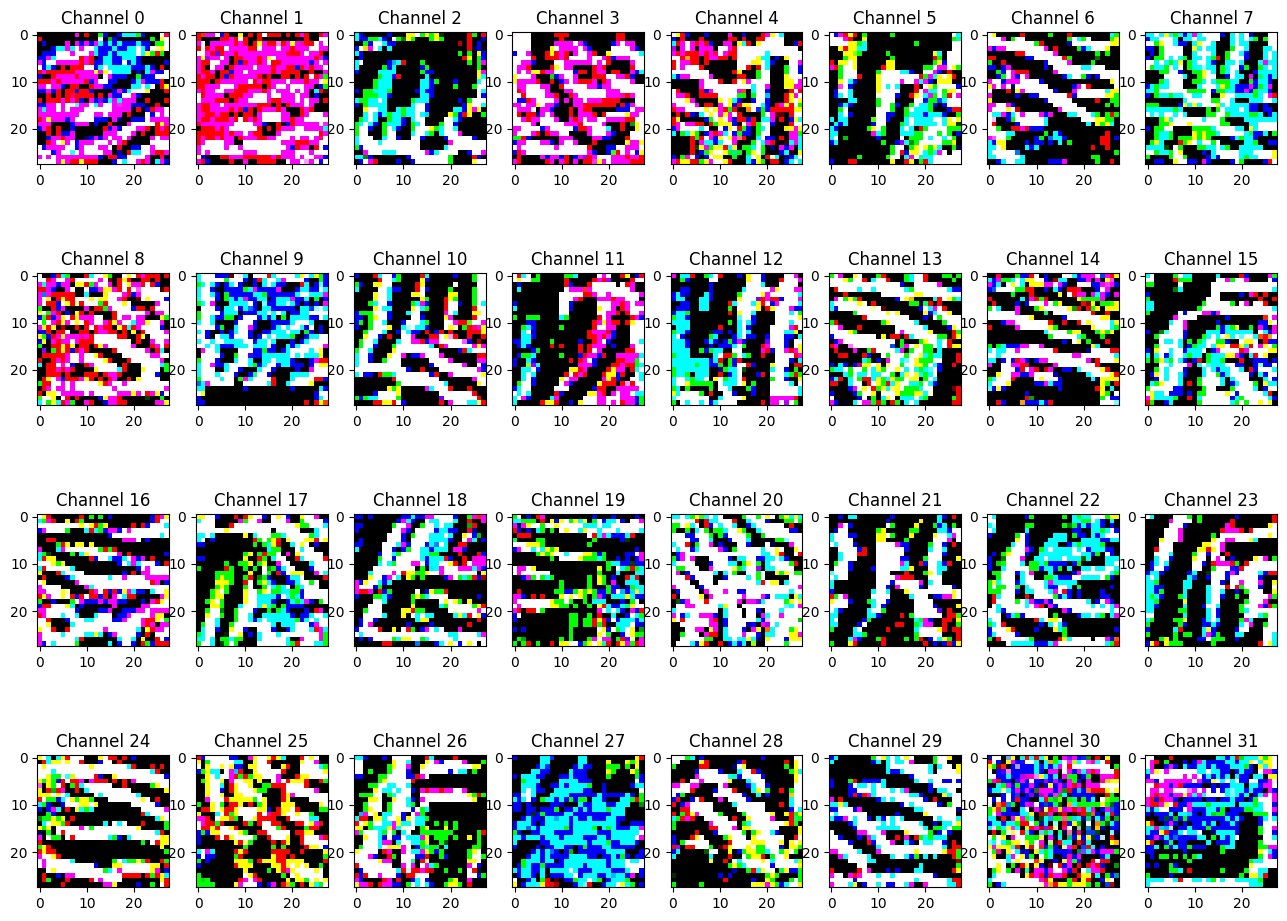

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 12))

for i in range(32):
  image = image_maximiser.maximiser(model.con_layer3,'layer3', i).squeeze(0)
  axes[i//8, i%8].imshow(einops.rearrange(image,'c h w -> h w c' ))

  axes[i//8, i%8].set_title(f"Channel {i}")

plt.show()

torch.Size([1, 16, 26, 26])
tensor(-6200.3506, device='cuda:0', grad_fn=<SumBackward0>) 0
tensor(-5688.5098, device='cuda:0', grad_fn=<SumBackward0>) 1
tensor(21755.5938, device='cuda:0', grad_fn=<SumBackward0>) 2
tensor(-1869.4395, device='cuda:0', grad_fn=<SumBackward0>) 3
tensor(-5986.1147, device='cuda:0', grad_fn=<SumBackward0>) 4
tensor(-3127.6287, device='cuda:0', grad_fn=<SumBackward0>) 5
tensor(-10792.7480, device='cuda:0', grad_fn=<SumBackward0>) 6
tensor(11034.8926, device='cuda:0', grad_fn=<SumBackward0>) 7
tensor(22343.5195, device='cuda:0', grad_fn=<SumBackward0>) 8
tensor(11686.9893, device='cuda:0', grad_fn=<SumBackward0>) 9
tensor(906.2056, device='cuda:0', grad_fn=<SumBackward0>) 10
tensor(-3943.3164, device='cuda:0', grad_fn=<SumBackward0>) 11
tensor(-8394.4883, device='cuda:0', grad_fn=<SumBackward0>) 12
tensor(-11533.5371, device='cuda:0', grad_fn=<SumBackward0>) 13
tensor(15411.6406, device='cuda:0', grad_fn=<SumBackward0>) 14
tensor(-14524.5879, device='cuda:0', 

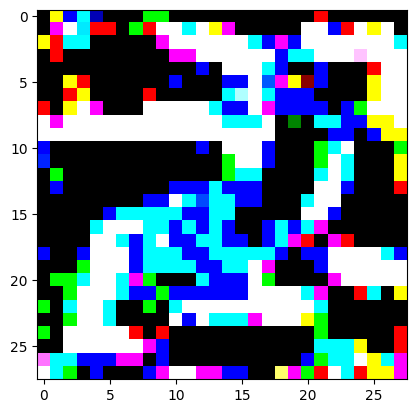

In [ ]:
image_maximiser = image_optimiser(model)
image = image_maximiser.maximiser(model.flat1,'layer1', 2)
plt.imshow(einops.rearrange(image.squeeze(), ' c h w -> h w c'))
image = torch.tensor(image)
image = image.to(device)

d = {}

def act_mat(name):
  def hook(model, input, output):
    d[name] = output
  return hook
model.con_layer1.register_forward_hook(act_mat('layer1'))
model(image)
print(d['layer1'].shape)
l = d['layer1'].squeeze()
for j,i in enumerate(l):
  print(i.sum(), j)

## Task 3: Grad Cam

In [ ]:
""" For simplicity of implementation we will use the grad_cam only at the
 last convolutional layer's feature maps."""

class Grad_Cam():
  def __init__(self, model):
    self.model = model
    self.model.eval()
    self.gradient = None
    self.f_maps = None
    self.grad_hook()

  def grad_hook(self):

    def forwd(model, input, output):
      self.f_maps = output
      def backward_hook(grad):
        self.gradient = grad
      output.register_hook(backward_hook)
    self.model.con_layer3.register_forward_hook(forwd)

  def heatmap_gen(self, image, class_index):
    model_pred = self.model(image)
    self.model.zero_grad()
    feature_maps = self.f_maps
    class_activation = model_pred[0, class_index]
    class_activation.backward()
    weight = torch.mean(self.gradient, dim = (2, 3), keepdim = True)

    fmap_activation = F.relu(torch.sum(weight * feature_maps , dim=1, keepdim=True))
    fmap_activation = fmap_activation - fmap_activation.min()
    fmap_activation = fmap_activation / fmap_activation.max()
    mask = F.interpolate(fmap_activation, size=(28, 28), mode='bilinear', align_corners=False)
    mask = mask.squeeze().detach().cpu().numpy()
    image = einops.rearrange(image.squeeze(), 'c h w -> h w c').squeeze().cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    mask = numpy.uint8(255 * mask)
    mask_colored = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
    mask_colored = cv2.cvtColor(mask_colored, cv2.COLOR_BGR2RGB) / 255.0
    superimposed = 0.6*mask_colored + 0.4 * image
    plt.imshow(superimposed)
    plt.show()





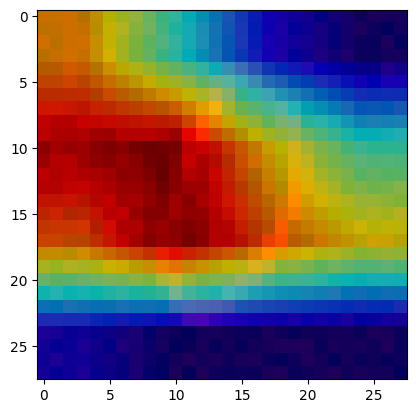

In [ ]:
g = Grad_Cam(model)
g.heatmap_gen(train_dataset[1168][0].unsqueeze(0).to(device), 0)

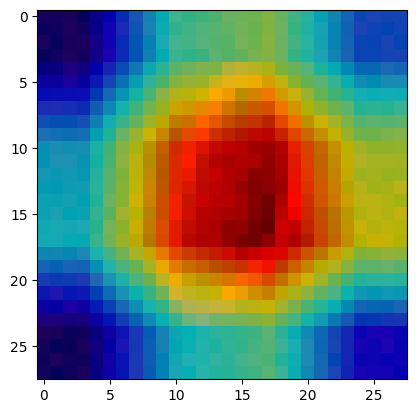

In [ ]:
g = Grad_Cam(modl)
g.heatmap_gen(train_dataset[1168][0].unsqueeze(0).to(device), 0)

# Robust Model

In [ ]:
def mask_creation(images, thresh):
  gray_img = images.mean(dim = 1, keepdim = True)

  mask = (gray_img > thresh)*1.0
  return mask

def test_loop(dataloader, model, loss_fn):

  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X = X.to(device)
      y = y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

      test_loss /= num_batches
      correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")



def new_loss_trainer(model, train_loader, test_dataloader, test_loss, lambda_color = 100000000000, epochs = 5, lambda_pen = 10000000000):
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  model = model.to(device)
  model.train()
  for epoch in range(epochs):
    loss_t = 0
    correct = 0
    tot = 0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      images.requires_grad = True
      pred = model(images)
      loss1 = F.cross_entropy(pred, labels)

      gradient_wrt_image = torch.autograd.grad(loss1, images, create_graph = True, retain_graph = True, only_inputs = True)[0]
      bg_mask = 1 - mask_creation(images, 0.6)
      norm_bg_grad = (bg_mask * gradient_wrt_image).pow(2).sum(dim = (1, 2, 3)).mean()

      foreground_grads = gradient_wrt_image * mask_creation(images, 0.6)
      color_penalty = foreground_grads.std(dim=1, keepdim=True).mean()
      total_loss = loss1 + norm_bg_grad * lambda_pen + lambda_color * color_penalty
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()
      loss_t += total_loss.item()
      _, predicted = pred.max(1)
      tot += labels.size(0)
      correct += predicted.eq(labels).sum().item()
    print(f"Epoch {epoch+1} | Acc: {100.*correct/tot:.2f}% | Loss: {loss_t/len(train_loader):.4f}")
    print(f" (Debug) CE: {loss1.item():.4f} | BG_Pen: {norm_bg_grad.item():.4f} | Color_Pen: {color_penalty.item():.4f}")
    test_loop(test_dataloader, model, test_loss)
  return model

test_loss_fn = nn.CrossEntropyLoss()

rob_model = CNN1(16, 16, 32)
robust_model = new_loss_trainer(rob_model, train_dataloader, test_dataloader, test_loss_fn)



Epoch 1 | Acc: 9.96% | Loss: 3999.6365
 (Debug) CE: 2.2979 | BG_Pen: 0.0000 | Color_Pen: 0.0000
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.009761 



KeyboardInterrupt: 

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size = batch_size , shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
rob_model = CNN1(16, 16, 32)
rob_model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rob_model.parameters(), lr=0.001, betas=(0.9, 0.999))

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):

    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


loss_fn = nn.CrossEntropyLoss()


epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, rob_model, loss_fn, optimizer)
    test_loop(test_dataloader, rob_model, loss_fn)
print("Done!")

Using cuda device
Epoch 1
-------------------------------
loss: 2.334957  [  256/60000]
loss: 0.474020  [25856/60000]
loss: 0.196805  [51456/60000]
Test Error: 
 Accuracy: 94.8%, Avg loss: 0.197858 

Epoch 2
-------------------------------
loss: 0.360596  [  256/60000]
loss: 0.154114  [25856/60000]
loss: 0.188777  [51456/60000]
Test Error: 
 Accuracy: 96.7%, Avg loss: 0.120446 

Epoch 3
-------------------------------
loss: 0.091218  [  256/60000]
loss: 0.089189  [25856/60000]
loss: 0.066053  [51456/60000]
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.078286 

Epoch 4
-------------------------------
loss: 0.082264  [  256/60000]
loss: 0.083504  [25856/60000]
loss: 0.042694  [51456/60000]
Test Error: 
 Accuracy: 98.4%, Avg loss: 0.060411 

Epoch 5
-------------------------------
loss: 0.021707  [  256/60000]
loss: 0.054316  [25856/60000]
loss: 0.039308  [51456/60000]
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.072084 

Done!


## PGD ATTACK

In [ ]:
class PGD_Attacker():
  def __init__(self, model, steps, epsilon, loss_func):

    self.model = model
    self.num_steps = steps
    self.epsilon = epsilon
    self.loss_func = loss_func
    self.step_size = 2.5*self.epsilon/self.num_steps


  def adversarial_image(self, input_image, target_label):

    self.model.eval()
    original_image = input_image.clone().detach().to(device)
    adversarial_image = input_image.clone().detach().to(device) + torch.FloatTensor(input_image.shape).uniform_(-self.epsilon, self.epsilon).to(device)

    for i in torch.arange(self.num_steps):
      adversarial_image.requires_grad = True
      output = self.model(adversarial_image)
      loss = self.loss_func(output.squeeze(), target_label)
      self.model.zero_grad()
      loss.backward()
      adversarial_image = adversarial_image.detach() - self.step_size*adversarial_image.grad.sign()
      adversarial_image = original_image + torch.clamp(adversarial_image - original_image, -self.epsilon, self.epsilon)
      adversarial_image = torch.clamp(adversarial_image, 0, 1)
    return adversarial_image.detach()


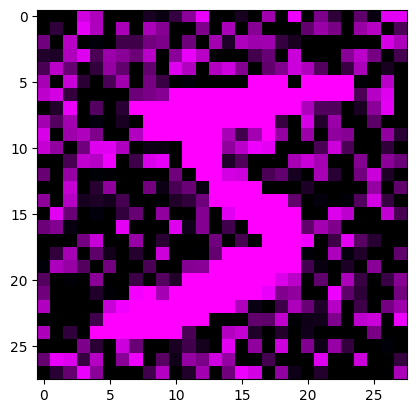

In [4]:
plt.imshow(einops.rearrange(train_dataset[0][0], 'c h w -> h w c'))

tensor([[-2.3591, -0.4300, -0.0703,  0.2640,  1.7968, -0.3880, -2.0010,  0.2545,
          0.3341, -0.1173]], grad_fn=<AddmmBackward0>)

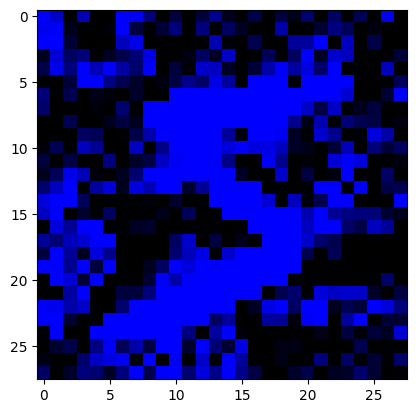

In [ ]:
loss_fn = nn.CrossEntropyLoss()
pgd = PGD_Attacker(model, 100, 0.5, loss_fn)
img = pgd.adversarial_image(train_dataset[0][0].unsqueeze(0), torch.tensor(2))
plt.imshow(einops.rearrange(img.squeeze(), 'c h w -> h w c'))
model(img)

# SAE

In [ ]:
class SAE(nn.Module):
  def __init__(self, input_dim, expansion_factor=10):
    super().__init__()
    self.input_dim = input_dim
    self.hidden_dim = input_dim * expansion_factor
    self.encoder = nn.Linear(input_dim, self.hidden_dim)
    self.enc_bias = nn.Parameter(torch.zeros(self.hidden_dim))
    self.decoder = nn.Linear(self.hidden_dim, input_dim, bias=False)
    self.dec_bias = nn.Parameter(torch.zeros(input_dim))

  def forward(self, x):
    x_centered = x - self.dec_bias
    f = torch.relu(self.encoder(x_centered) + self.enc_bias)
    rec = self.decoder(f) + self.dec_bias
    return rec, f

activation_data = []

def harvest_hook(module, input, output):

    hidden_state = input[0].detach().cpu()
    activation_data.append(hidden_state)

handle = rob_model.flat1.register_forward_hook(harvest_hook)

rob_model.eval()
with torch.no_grad():
    count = 0
    for images, _ in train_dataloader:
        rob_model(images.to(device))
        count += images.size(0)
        if count >= 5000: break

handle.remove()
sae_dataset = torch.cat(activation_data, dim=0)
print(f"captured Features Shape: {sae_dataset.shape}")

captured Features Shape: torch.Size([5120, 128])


In [ ]:
input_dim = sae_dataset.shape[1]
lr = 1e-3
loss_coeff = 3e-4

SAEE = SAE(input_dim).to(device)
optimizer = torch.optim.Adam(SAEE.parameters(), lr=lr)
sae_loader = DataLoader(TensorDataset(sae_dataset), batch_size=batch_size, shuffle=True)
ep = 15
for epoch in range(ep):
  ep_loss = 0
  ep_rec = 0
  ep_sparse = 0

  for (batch_x,) in sae_loader:
    batch_x = batch_x.to(device)
    recon, features = SAEE(batch_x)
    loss_rec = nn.MSELoss()(recon, batch_x)
    loss_sparse = loss_coeff * features.abs().sum(dim=1).mean()

    total_loss = loss_rec + loss_sparse

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    ep_loss += total_loss.item()
    ep_rec += loss_rec.item()
    ep_sparse += loss_sparse.item()
  print(f"Epoch {epoch+1:02d} | Total: {ep_loss/len(sae_loader):.4f} | Recon: {ep_rec/len(sae_loader):.4f} | Sparse: {ep_sparse/len(sae_loader):.4f}")


Epoch 01 | Total: 24.8602 | Recon: 24.1469 | Sparse: 0.7133
Epoch 02 | Total: 7.4585 | Recon: 6.8281 | Sparse: 0.6304
Epoch 03 | Total: 4.8508 | Recon: 4.2344 | Sparse: 0.6164
Epoch 04 | Total: 3.6812 | Recon: 3.0532 | Sparse: 0.6281
Epoch 05 | Total: 2.9893 | Recon: 2.3564 | Sparse: 0.6329
Epoch 06 | Total: 2.5148 | Recon: 1.8902 | Sparse: 0.6246
Epoch 07 | Total: 2.1758 | Recon: 1.5633 | Sparse: 0.6125
Epoch 08 | Total: 1.9146 | Recon: 1.3182 | Sparse: 0.5963
Epoch 09 | Total: 1.7116 | Recon: 1.1327 | Sparse: 0.5789
Epoch 10 | Total: 1.5542 | Recon: 0.9939 | Sparse: 0.5604
Epoch 11 | Total: 1.4222 | Recon: 0.8793 | Sparse: 0.5429
Epoch 12 | Total: 1.3134 | Recon: 0.7883 | Sparse: 0.5251
Epoch 13 | Total: 1.2140 | Recon: 0.7056 | Sparse: 0.5083
Epoch 14 | Total: 1.1338 | Recon: 0.6409 | Sparse: 0.4928
Epoch 15 | Total: 1.0609 | Recon: 0.5832 | Sparse: 0.4778


In [ ]:

SAEE.eval()
with torch.no_grad():
    sample_batch = next(iter(sae_loader))[0].to(device)
    _, features = SAEE(sample_batch)
    l0_norm = (features > 0).float().sum(dim=1).mean()
    print(f"{l0_norm.item():.1f}")


536.1


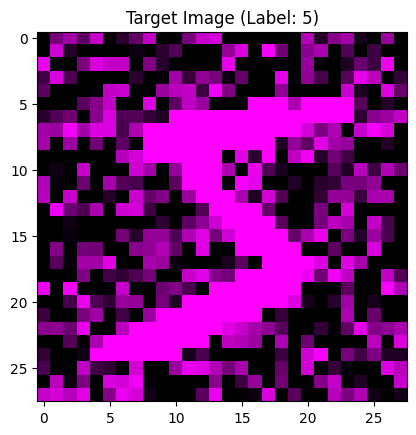


Top Active SAE Features for this image:
Feature Index 472 | Activation Strength: 13.2719
Feature Index 295 | Activation Strength: 12.6898
Feature Index 511 | Activation Strength: 11.4416

Targeting Feature 472 for deletion...


In [ ]:
import matplotlib.pyplot as plt

def find_top_features(model, sae, image, device):

    model.eval()
    SAEE.eval()
    hidden_state = []
    def hook(module, input, output):
        data = input[0].detach()
        if len(data.shape) > 2: data = data.view(data.size(0), -1)
        hidden_state.append(data)

    handle = model.flat1.register_forward_hook(hook)
    with torch.no_grad():
        model(image.unsqueeze(0).to(device))

    handle.remove()

    act = hidden_state[0].to(device)
    _, features = SAEE(act)
    values, indices = torch.topk(features, k=3)

    return values[0], indices[0]

red_img, label = train_dataset[0]

plt.imshow(red_img.permute(1, 2, 0))
plt.title(f"Target Image (Label: {label})")
plt.show()
vals, idxs = find_top_features(rob_model, SAEE, red_img, device)
print(f"\nTop Active SAE Features for this image:")
for v, i in zip(vals, idxs):
    print(f"Feature Index {i.item()} | Activation Strength: {v.item():.4f}")
target_feature_idx = idxs[0].item()
print(f"\nTargeting Feature {target_feature_idx} for deletion...")

In [ ]:
def steer_model(model, sae, image, feature_idx, strength):
    model.eval()
    feature_vector = sae.decoder.weight[:, feature_idx].detach()
    def intervention_hook(module, input):
        hidden = input[0]
        if len(hidden.shape) > 2:
            hidden = hidden.view(hidden.size(0), -1)
        hidden = hidden + (feature_vector * strength)

        return (hidden, )
    handle = model.flat1.register_forward_pre_hook(intervention_hook)

    with torch.no_grad():
        pred_logits = model(image.unsqueeze(0).to(device))

    handle.remove()
    return pred_logits

base_logits = rob_model(red_img.unsqueeze(0).to(device))
base_pred = base_logits.argmax(1).item()
print(f"Baseline Prediction: {base_pred} (Confidence: {base_logits.softmax(1).max().item():.2f})")

strength = -20.0
new_logits = steer_model(rob_model, SAEE, red_img, target_feature_idx, strength)
new_pred = new_logits.argmax(1).item()

print(f"Intervened Pred: {new_pred} (Str: {strength})")
print(f"New Conf: {new_logits.softmax(1).max().item():.2f}")

if

Baseline Prediction: 5 (Confidence: 0.85)
Intervened Prediction: 3 (Strength: -20.0)
New Confidence: 0.52

SUCCESS! You successfully steered the model by deleting the color feature.
